In [50]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt

from pprint import pprint

import src
from src.reload import deep_reload

In [2]:
'''
Loading the graph with adjacency

graph contains 15 cities in cities.json and all CA DC charging stations from AFDC
'''

graph = src.graph.graph_from_json('Outputs/graph_full.json')

In [3]:
deep_reload(src)

graph = src.routing.edge_types(graph)

In [5]:
cities = [k for k, v in graph._node.items() if v['type'] == 'city']

tesla_stations = [k for k, v in graph._node.items() if v.get('network', '') == 'Tesla']
non_proprietary_stations = (
    [k for k, v in graph._node.items() if v.get('network', '') \
     not in ['Tesla', 'RIVIAN_ADVENTURE']]
)

tesla_sng = src.graph.subgraph(graph, tesla_stations + cities)
non_proprietary_sng = src.graph.subgraph(graph, non_proprietary_stations + cities)

In [9]:
deep_reload(src)

objective = src.routing.Scout(field = 'time', edge_limit = 3800)

t0 = time.time()

costs, values, paths = src.routing.all_pairs_shortest_paths(
    tesla_sng, cities, objective = objective, return_paths = True
)

print(f'Executed in {time.time() - t0:.4f} seconds')

tesla_utilized_stations = list(np.unique(
    np.concatenate(
        [n[1: -1] for paths_source in paths.values() for n in paths_source.values()]
    )
))

len(tesla_utilized_stations)

 [------------>] (15/15) 100.00%, 15.37 it/s, 1.04 s elapsed, 0.00 s remainingExecuted in 1.0422 seconds


104

In [10]:
deep_reload(src)

objective = src.routing.Scout(field = 'time', edge_limit = 3800)

t0 = time.time()

costs, values, paths = src.routing.all_pairs_shortest_paths(
    non_proprietary_sng, cities, objective = objective, return_paths = True
)

print(f'Executed in {time.time() - t0:.4f} seconds')

non_proprietary_utilized_stations = list(np.unique(
    np.concatenate(
        [n[1: -1] for paths_source in paths.values() for n in paths_source.values()]
    )
))

len(non_proprietary_utilized_stations)

 [------------->] (15/15) 100.00%, 2.28 it/s, 7.02 s elapsed, 0.00 s remainingExecuted in 7.0207 seconds


217

In [11]:
combined_utilized_stations = tesla_utilized_stations + non_proprietary_utilized_stations

In [74]:
non_proprietary_sng_us = src.graph.subgraph(
    graph, non_proprietary_utilized_stations + cities
)

tesla_sng_us = src.graph.subgraph(
    graph, tesla_utilized_stations + cities
)

combined_sng_us = src.graph.subgraph(
    graph, combined_utilized_stations + cities
)

In [76]:
src.graph.graph_to_json(non_proprietary_sng_us, 'Outputs/SNG/non_proprietary_sng_us.json')
src.graph.graph_to_json(tesla_sng_us, 'Outputs/SNG/tesla_sng_us.json')
src.graph.graph_to_json(combined_sng_us, 'Outputs/SNG/combined_sng_us.json')

In [52]:
deep_reload(src)

vehicle_kw = {
    'capacity': 80 * 3.6e6,
    'max_charge_start_soc': .5,
    'efficiency': 550,
    'charge_rate': 80e3,
    'cases': 100,
}

station_kw = {
    'cases': 100,
}

costs, values, paths = src.experiments.run_case(
    tesla_sng_us, vehicle_kw, station_kw, method = 'bellman'
)

 [------------>] (15/15) 100.00%, 0.44 it/s, 36.10 s elapsed, 0.00 s remaining

In [119]:
risk_attitudes = [(0, .5), (0, 1), (.5, 1)]
capacities = [49.16 * 3.6e6, 73.75 * 3.6e6, 98.33 * 3.6e6]
charge_rates = [c / 3.6e3 / .75 for c in capacities]
reliabilities = [.75, .85, .95]
sngs = [tesla_sng_us, non_proprietary_sng_us, combined_sng_us]

levels = src.utilities.full_factorial([3, 3, 3, 3])

# capacities, [c / 1e3 for c in charge_rates]

vehicle_kw = []
station_kw = []

for case in levels:

    vehicle_kw.append({
        'capacity': capacities[case[1]],
        'risk_attitude': risk_attitudes[case[0]],
        # 'max_charge_start_soc': .5,
        'efficiency': 550,
        'charge_rate': charge_rates[case[1]],
        'charge_target_soc': .8,
        'cases': 100,
    })
    
    station_kw.append({
        'cases': 100,
        'charge_rate': charge_rates[case[1]],
        'reliability': reliabilities[case[2]],
        'base_delay': 60,
    })

In [142]:
deep_reload(src)

idx = 3

costs, values, paths = src.experiments.run_case(
    sngs[levels[idx][3]], vehicle_kw[idx], station_kw[idx], method = 'bellman'
)

In [143]:
paths['Redding']

{'Bakersfield': ['Redding', 'station_1463', 'Bakersfield'],
 'Chico': ['Redding', 'station_1463', 'Chico'],
 'Fresno': ['Redding', 'station_1463', 'Fresno'],
 'Los Angeles': ['Redding', 'station_1463', 'Los Angeles'],
 'Redding': ['Redding'],
 'Sacramento': ['Redding', 'station_1463', 'Sacramento'],
 'San Diego': ['Redding', 'station_1463', 'San Diego'],
 'San Francisco': ['Redding', 'station_1463', 'San Francisco'],
 'San Jose': ['Redding', 'station_1463', 'San Jose'],
 'Stockton': ['Redding', 'station_1463', 'Stockton'],
 'Yreka': ['Redding', 'station_1463', 'Yreka'],
 'Crescent City': ['Redding', 'station_1463', 'Crescent City'],
 'I-80 to Reno (State Line)': ['Redding',
  'station_1463',
  'I-80 to Reno (State Line)'],
 'I-15 to Las Vegas (State Line)': ['Redding',
  'station_1463',
  'I-15 to Las Vegas (State Line)'],
 'I-10 to Phoenix (State Line)': ['Redding',
  'station_1463',
  'I-10 to Phoenix (State Line)']}

In [144]:
costs['Redding']

{'Redding': 0,
 'Crescent City': 13435.418543217362,
 'Yreka': 5229.815758502074,
 'Chico': 4122.888273487091,
 'I-80 to Reno (State Line)': 13723.149062697883,
 'Sacramento': 8444.190071688896,
 'Stockton': 10983.267494266322,
 'San Francisco': 11585.908478282301,
 'San Jose': 13272.542219541047,
 'Fresno': 17997.670591169397,
 'I-15 to Las Vegas (State Line)': 38525.133690569986,
 'Bakersfield': 23697.434202558048,
 'Los Angeles': 28966.13962213842,
 'I-10 to Phoenix (State Line)': 41147.776735025545,
 'San Diego': 36128.18557618445,
 'station_1425': 13711.570273868849,
 'station_784': 27448.83518017943,
 'station_1534': 10870.887198957034,
 'station_84': 26175.62301291082,
 'station_85': 41458.97226240041,
 'station_86': 26421.545671512013,
 'station_87': 37448.93231097069,
 'station_88': 31501.05913541971,
 'station_89': 33183.86377597876,
 'station_90': 27663.46310469144,
 'station_91': 39423.459121782704,
 'station_92': 21381.472452419093,
 'station_93': 11950.387078677286,
 'sta

In [71]:
pkl.dump([costs, values, paths], open(f'Outputs/Experiment/case_{idx}.pkl', 'wb'))

In [99]:
costs, values, paths = pkl.load(open('Outputs/Experiment/case_47.pkl', 'rb'))

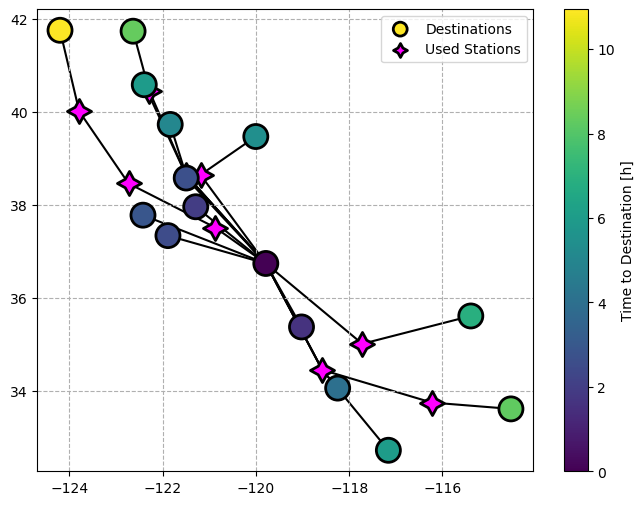

In [100]:
deep_reload(src)

fig, ax = plt.subplots(figsize = (8, 6))

destinations = [k for k, v in graph._node.items() if 'station' not in k]

src.figures.plot_route_tree(
    ax, graph,
    {k: v['time'].mean() / 3600 for k, v in values['Fresno'].items()},
    # {},
    {k: v for k, v in paths['Fresno'].items() if 'station' not in k},
    destinations = destinations,
    show_unused_stations = False,
    **src.figures.default_route_tree_kwargs,
)

legend = ax.legend()

for h in legend.legendHandles:
    h._sizes = [100]

    ax.grid(ls = '--')

# plt.colorbar(cax = ax)

In [84]:
print('Total Time:\n')
pprint({k: v['time'].mean() / 3600 for k, v in values['Fresno'].items() if 'station' not in k})
print('\nDriving Time:\n')
pprint({k: v['driving_time'].mean() / 3600 for k, v in values['Fresno'].items() if 'station' not in k})
print('\nPaths:\n')
pprint({k: v for k, v in paths['Fresno'].items() if 'station' not in k})

Total Time:

{'Bakersfield': 1.6082676698301694,
 'Chico': 4.871409984610372,
 'Crescent City': 12.925664083731014,
 'Fresno': 0.0,
 'I-10 to Phoenix (State Line)': 8.343215641055375,
 'I-15 to Las Vegas (State Line)': 7.2357495746473495,
 'I-80 to Reno (State Line)': 5.368145004935189,
 'Los Angeles': 3.8887643065557222,
 'Redding': 6.197152731897118,
 'Sacramento': 2.9912605983275604,
 'San Diego': 6.201776607627548,
 'San Francisco': 2.9443037864912918,
 'San Jose': 2.833782493099451,
 'Stockton': 2.2790847186516747,
 'Yreka': 8.349967010958686}

Driving Time:

{'Bakersfield': 1.6082676698301694,
 'Chico': 4.250115363802866,
 'Crescent City': 8.605738955488931,
 'Fresno': 0.0,
 'I-10 to Phoenix (State Line)': 6.736902264402265,
 'I-15 to Las Vegas (State Line)': 5.898763392857147,
 'I-80 to Reno (State Line)': 4.59146112567988,
 'Los Angeles': 3.263417207792206,
 'Redding': 5.235482711732716,
 'Sacramento': 2.671335470085477,
 'San Diego': 5.342571386946395,
 'San Francisco': 2.9443

In [49]:
cases = 3 * 3 * 3 * 2

avg_time = (1 / .27 + 1 / .13 + 15 * 30) / 3

cases * avg_time / 3600

2.306980056980057

In [39]:
'''
Adding station objects
'''
deep_reload(src)

sng = tesla_sng_us

vehicle = src.routing.StochasticVehicle(
    capacity = 80 * 3.6e6,
    max_charge_start_soc = .5,
)

for source, node in sng._node.items():

    if node['type'] == 'station':

        node['station'] = src.routing.StochasticStation(
            chargers = node['n_dcfc'], cases = 100,
        )

In [40]:
'''
Running with Bellman with BEV stochastic vehicle objective
'''
deep_reload(src)

vehicle = src.routing.StochasticVehicle(
    capacity = 80 * 3.6e6,
    max_charge_start_soc = .5,
    cases = 100
)

t0 = time.time()

costs, values, paths = src.routing.all_pairs_shortest_paths(
    sng, cities, objective = vehicle, method = 'bellman', return_paths = True
)


print(f'Executed in {time.time() - t0:.4f} seconds')

 [------------>] (15/15) 100.00%, 0.44 it/s, 36.53 s elapsed, 0.00 s remainingExecuted in 36.5291 seconds


In [90]:
levels[:27], levels[27:54], levels[54:81], levels[80]

(array([[0, 0, 0, 0],
        [1, 0, 0, 0],
        [2, 0, 0, 0],
        [0, 1, 0, 0],
        [1, 1, 0, 0],
        [2, 1, 0, 0],
        [0, 2, 0, 0],
        [1, 2, 0, 0],
        [2, 2, 0, 0],
        [0, 0, 1, 0],
        [1, 0, 1, 0],
        [2, 0, 1, 0],
        [0, 1, 1, 0],
        [1, 1, 1, 0],
        [2, 1, 1, 0],
        [0, 2, 1, 0],
        [1, 2, 1, 0],
        [2, 2, 1, 0],
        [0, 0, 2, 0],
        [1, 0, 2, 0],
        [2, 0, 2, 0],
        [0, 1, 2, 0],
        [1, 1, 2, 0],
        [2, 1, 2, 0],
        [0, 2, 2, 0],
        [1, 2, 2, 0],
        [2, 2, 2, 0]]),
 array([[0, 0, 0, 1],
        [1, 0, 0, 1],
        [2, 0, 0, 1],
        [0, 1, 0, 1],
        [1, 1, 0, 1],
        [2, 1, 0, 1],
        [0, 2, 0, 1],
        [1, 2, 0, 1],
        [2, 2, 0, 1],
        [0, 0, 1, 1],
        [1, 0, 1, 1],
        [2, 0, 1, 1],
        [0, 1, 1, 1],
        [1, 1, 1, 1],
        [2, 1, 1, 1],
        [0, 2, 1, 1],
        [1, 2, 1, 1],
        [2, 2, 1, 1],
        